In [1]:
import os
import os.path
from os import walk
from os.path import join
import numpy as np
from tqdm import tqdm

base_path = '/atlas/home/zwpeng/paper_rebuild/camelyon_data/'

def get_picture(path):
    path0 = join(base_path + path)
    picture = []
    for _,_,filenames in tqdm(walk(path0)):
        for filename in filenames:
            file_prefix = os.path.splitext(filename)[0]
            if os.path.exists(join(path0, file_prefix + ".tif")):
                picture.append(filename)
            else:
                print("路径不对或者没有这种格式的文件")
    return picture

In [2]:
train_set = get_picture("train/tumor/origin_images/")    # 训练集数据文件夹
valid_set = get_picture("validation/")    # 验证集数据文件夹
mask_pictures = get_picture("train/tumor/annotation_images/")    # 所有的mask图文件夹

print(len(train_set), len(valid_set), len(mask_pictures))
print("训练数据集是：\n",train_set)
print("验证数据集是：\n",valid_set)

print("所有数据对应的mask图是：\n",mask_pictures)

1it [00:00, 1215.74it/s]
1it [00:00, 1753.47it/s]
1it [00:00, 204.18it/s]

32 13 110
训练数据集是：
 ['Tumor_002.tif', 'Tumor_011.tif', 'Tumor_012.tif', 'Tumor_019.tif', 'Tumor_022.tif', 'Tumor_043.tif', 'Tumor_045.tif', 'Tumor_050.tif', 'Tumor_060.tif', 'Tumor_066.tif', 'Tumor_067.tif', 'Tumor_073.tif', 'Tumor_074.tif', 'Tumor_079.tif', 'Tumor_081.tif', 'Tumor_083.tif', 'Tumor_085.tif', 'Tumor_090.tif', 'Tumor_093.tif', 'Tumor_094.tif', 'Tumor_095.tif', 'Tumor_097.tif', 'Tumor_098.tif', 'Tumor_099.tif', 'Tumor_100.tif', 'Tumor_110.tif', 'Tumor_005.tif', 'Tumor_016.tif', 'Tumor_025.tif', 'Tumor_049.tif', 'Tumor_065.tif', 'Tumor_069.tif']
验证数据集是：
 ['Tumor_030.tif', 'Tumor_053.tif', 'Tumor_057.tif', 'Tumor_059.tif', 'Tumor_041.tif', 'Tumor_042.tif', 'Tumor_107.tif', 'Tumor_109.tif', 'Tumor_072.tif', 'Tumor_092.tif', 'Tumor_031.tif', 'Tumor_039.tif', 'Tumor_051.tif']
所有数据对应的mask图是：
 ['Tumor_005_Mask.tif', 'Tumor_016_Mask.tif', 'Tumor_019_Mask.tif', 'Tumor_001_Mask.tif', 'Tumor_002_Mask.tif', 'Tumor_003_Mask.tif', 'Tumor_004_Mask.tif', 'Tumor_006_Mask.tif', 'Tumor_007_M

In [3]:
import openslide

def path_to_slide(random_choice):
    random_choice_path = join(base_path, "train/tumor/origin_images/" + random_choice)
    random_mask_path = join(base_path, "train/tumor/annotation_images/" + (random_choice.split("."))[0] + "_Mask.tif")
#     print("随机选取一张训练集图的路径是：", random_choice_path)
#     print("该图片对应的mask路径是：", random_mask_path)
    origin_slide = openslide.open_slide(random_choice_path)
    mask_slide = openslide.open_slide(random_mask_path)
    return origin_slide, mask_slide

def path_to_slide_valid(random_choice):
    random_choice_path = join(base_path, "validation/" + random_choice)
    random_mask_path = join(base_path, "train/tumor/annotation_images/" + (random_choice.split("."))[0] + "_Mask.tif")
#     print("随机选取一张验证集的路径是：", random_choice_path)
#     print("该图片对应的mask路径是：", random_mask_path)
    origin_slide = openslide.open_slide(random_choice_path)
    mask_slide = openslide.open_slide(random_mask_path)
    return origin_slide, mask_slide

def path_to_slide_test(random_choice):
    random_choice_path = join(base_path, "test/" + random_choice)
    random_mask_path = join(base_path, "train/tumor/annotation_images/" + (random_choice.split("."))[0] + "_Mask.tif")
#     print("随机选取一张测试集的路径是：", random_choice_path)
#     print("该图片对应的mask路径是：", random_mask_path)
    origin_slide = openslide.open_slide(random_choice_path)
    mask_slide = openslide.open_slide(random_mask_path)
    return origin_slide, mask_slide

In [4]:
from pylab import *
import numpy as np

# 感兴趣区域锁定函数
def locate_ROI(origin_slide,level=6):
    origin_widths,origin_heights = origin_slide.dimensions

    object_widths,object_heights = origin_slide.level_dimensions[level]

    rgb_list_y = list()
    rgb_list_x = list()
    rgb_var_x = []
    rgb_var_y = []
    rgb_var_xi = []
    rgb_var_yi = []

    # 寻找有效区域的y值、高度
    for k in range(100):
        slide = origin_slide.read_region((0, k*origin_heights//100), level, (object_widths, object_heights//50)) 
        slide_arr = array(slide.convert("RGB"))
        rgb_list_y.append(((slide_arr[:,:,0]).mean(), (slide_arr[:,:,1]).mean(), (slide_arr[:,:,2]).mean()))
    for i,rgbVar in enumerate(rgb_list_y):
        rgb_var_y.append(np.var(rgbVar))
        if np.var(rgbVar)>=1:
            rgb_var_yi.append(i)

    effective_y = min(rgb_var_yi)*origin_heights//100        #有效区域的左上顶点y坐标找到了
    effective_heights = (max(rgb_var_yi)-min(rgb_var_yi))*origin_heights//100 + origin_heights//50  #有效区域的高度也出来了
#     print("有效区域的ｙ值是：%d" %effective_y, "有效区域的高度是：%d" %effective_heights)

    # 寻找有效区域的x值、宽度
    for j in range(100):
        slide = origin_slide.read_region((j*origin_widths//100, effective_y), level, 
                                          (object_widths//50, effective_heights//62))     # 循环顺序读取50宽的区域

        slide_arr = array(slide.convert("RGB"))
        rgb_list_x.append(((slide_arr[:,:,0]).mean(), (slide_arr[:,:,1]).mean(), (slide_arr[:,:,2]).mean()))
    for i,rgbVar in enumerate(rgb_list_x):
        rgb_var_x.append(np.var(rgbVar))
        if np.var(rgbVar)>=2:
            rgb_var_xi.append(i)

    effective_x = min(rgb_var_xi)*origin_widths//100        # 有效区域的左上顶点y坐标找到了
    effective_widths = (max(rgb_var_xi) - min(rgb_var_xi))*origin_widths//100 + origin_widths//50  # 有效区域的宽度也出来了
    return effective_x,effective_y,effective_widths,effective_heights

In [5]:
from pylab import *
import numpy as np

def locate_ROI_mask(mask_slide,mask_level=7):
    # level0　的尺寸
    mask_widths, mask_heights = mask_slide.dimensions
    # level7 的尺寸
    mask_level_widths, mask_level_heights = mask_slide.level_dimensions[mask_level]

    mask_level_slide = mask_slide.read_region((0, 0), mask_level, (mask_level_widths, mask_level_heights))
    mask_level_slide_gray = mask_level_slide.convert("L")
    mask_level_slide_arr = array(mask_level_slide_gray)

    mask_y, mask_x = nonzero(mask_level_slide_arr)  # 因为mask是黑白图，只需直接获得非零像素的坐标
    # mask_x, mask_y
    tumor_leftup_x = (min(mask_x)-1) * int(mask_slide.level_downsamples[mask_level])
    tumor_leftup_y = (min(mask_y)-1) * int(mask_slide.level_downsamples[mask_level])
    tumor_rightdown_x = (max(mask_x)+1) * int(mask_slide.level_downsamples[mask_level])
    tumor_rightdown_y = (max(mask_y)+1) * int(mask_slide.level_downsamples[mask_level])
    
#     print(tumor_leftup_x,tumor_leftup_y,tumor_rightdown_x,tumor_rightdown_y)
    mask_effective_widths = tumor_rightdown_x - tumor_leftup_x
    mask_effective_heights = tumor_rightdown_y - tumor_leftup_y
    
#     mask_tumor_area = ((max(mask_x)-min(mask_x)+2)*int(mask_slide.level_downsamples[mask_level]), 
#                        (max(mask_y)-min(mask_y)+2)*int(mask_slide.level_downsamples[mask_level]))
#     print(mask_tumor_area)        # mask区域的长宽
    return tumor_leftup_x,tumor_leftup_y,mask_effective_widths,mask_effective_heights

In [6]:
def effective_list(data_set):
    random_set = {}
#     random_choice = np.random.choice(data_set)    # 随机从数据集列表中选取一张图片路径
    for i in tqdm(range(len(data_set))):
        if data_set == train_set:
            origin_slide, mask_slide = path_to_slide(data_set[i])
        elif data_set == valid_set:
            origin_slide, mask_slide = path_to_slide_valid(data_set[i])
        elif data_set == test_set:
            origin_slide, mask_slide = path_to_slide_test(data_set[i])
        else:
            print("数据集加载不正确")

        try:
            [[effective_x,effective_y,effective_widths,effective_heights],
             [tumor_leftup_x,tumor_leftup_y,mask_effective_widths,mask_effective_heights]] = random_set[data_set[i]]
        except KeyError:
            effective_x,effective_y,effective_widths,effective_heights = locate_ROI(origin_slide)            
            tumor_leftup_x,tumor_leftup_y,mask_effective_widths,mask_effective_heights = locate_ROI_mask(mask_slide)
            random_set[data_set[i]] = [[effective_x,effective_y,effective_widths,effective_heights],
                                         [tumor_leftup_x,tumor_leftup_y,mask_effective_widths,mask_effective_heights]]
    return random_set

In [7]:
from datetime import datetime

start_time = datetime.now()

eff_train = effective_list(train_set)    # 所有训练数据的有效区域　存放字典
# eff_valid = effective_list(valid_set)    # 所有验证数据的有效区域　存放字典
# eff_test = effective_list(test_set)    # 所有测试数据的有效区域　存放字典
# print(len(eff_train),len(eff_valid),len(eff_test))
print(eff_train, '\n')
# print(eff_valid, '\n')
# print(eff_test, '\n')

end_time = datetime.now()
print('本段代码执行时间是：%.2f s'%(end_time-start_time).seconds)

100%|██████████| 32/32 [01:02<00:00,  1.97s/it]

{'Tumor_073.tif': [[0, 0, 116653, 88309], [43392, 58880, 4736, 6016]], 'Tumor_083.tif': [[0, 0, 121855, 91391], [57216, 6144, 26880, 9088]], 'Tumor_002.tif': [[18580, 85662, 52806, 63696], [46336, 102400, 1280, 2176]], 'Tumor_005.tif': [[18580, 125199, 41071, 50518], [57600, 136320, 2048, 3712]], 'Tumor_022.tif': [[18385, 101744, 55157, 92896], [51712, 108032, 4480, 2432]], 'Tumor_050.tif': [[10757, 79943, 76276, 88585], [67200, 138624, 2944, 5760]], 'Tumor_100.tif': [[10690, 10752, 87899, 70784], [57856, 36480, 2432, 3712]], 'Tumor_074.tif': [[0, 0, 133324, 89993], [20992, 70912, 5120, 7808]], 'Tumor_095.tif': [[0, 0, 141065, 89241], [14976, 53248, 61184, 39552]], 'Tumor_065.tif': [[35205, 75028, 35204, 61787], [37632, 83584, 20224, 19840]], 'Tumor_019.tif': [[53785, 72483, 18579, 87858], [60288, 88576, 2432, 2816]], 'Tumor_012.tif': [[37160, 49576, 31292, 81909], [47104, 76416, 2432, 768]], 'Tumor_081.tif': [[9011, 0, 58572, 84295], [41344, 41216, 1280, 896]], 'Tumor_069.tif': [[1564

In [8]:
random_pic = np.random.choice(train_set)
random_pic = 'Tumor_090.tif'
random_pic

'Tumor_090.tif'

In [11]:
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

start = datetime.now()
slide, truth = path_to_slide(random_pic)

print(slide.level_count, slide.level_dimensions, slide.level_downsamples, '\n')
print(truth.level_count, truth.level_dimensions, truth.level_downsamples, '\n')

end = datetime.now()
print('本段代码执行时间是:%.1f s'%(end-start).seconds)

10 ((151552, 111104), (75776, 55808), (37888, 28160), (18944, 14336), (9728, 7168), (5120, 3584), (2560, 2048), (1536, 1024), (1024, 512), (512, 512)) (1.0, 1.9954128440366974, 3.9727272727272727, 7.875, 15.539473684210527, 30.3, 56.725, 103.58333333333334, 182.5, 256.5) 

8 ((151552, 111104), (75776, 55552), (37888, 27776), (18944, 13888), (9472, 6944), (4736, 3472), (2368, 1736), (1184, 868)) (1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0) 

本段代码执行时间是:0.0 s


19
本段代码执行时间是:0.0 s


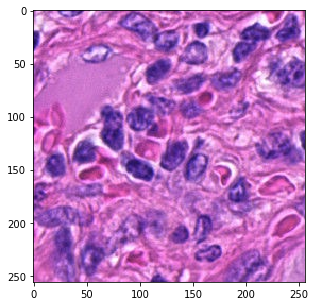

In [12]:
from datetime import datetime
import matplotlib.pyplot as plt
from openslide.deepzoom import DeepZoomGenerator 
%matplotlib inline

start = datetime.now()
slide, truth = path_to_slide(random_pic)

tiles = DeepZoomGenerator(slide, tile_size=256, overlap=0, limit_bounds=False)
tiles_truth = DeepZoomGenerator(truth, tile_size=256, overlap=0, limit_bounds=False)

print(tiles.level_count)
# print(slide.level_count, slide.level_dimensions, slide.level_downsamples, '\n')
# print(truth.level_count, truth.level_dimensions, truth.level_downsamples, '\n')

f, ax = plt.subplots(figsize=(5,5))
ax.imshow(tiles.get_tile(tiles.level_count-1,(100,100)))
end = datetime.now()
print('本段代码执行时间是:%.1f s'%(end-start).seconds)

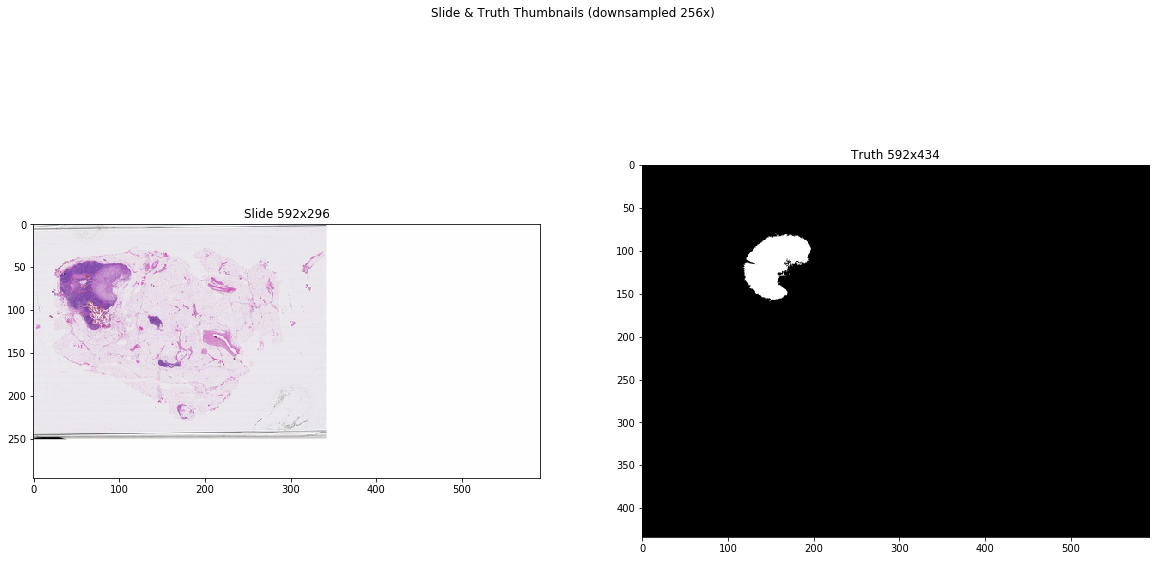

In [13]:
thumbnail = slide.get_thumbnail((slide.dimensions[0] / 256, slide.dimensions[1] / 256))
thumbnail_truth = truth.get_thumbnail((truth.dimensions[0] / 256, truth.dimensions[1] / 256)) 

f, axes = plt.subplots(1, 2, figsize=(20, 10));
ax = axes.ravel()
ax[0].imshow(thumbnail);
ax[0].set_title('Slide %dx%d' % thumbnail.size)
ax[1].imshow(thumbnail_truth.convert('L'), cmap='gray');
ax[1].set_title('Truth %dx%d' % thumbnail_truth.size)
f.suptitle('Slide & Truth Thumbnails (downsampled 256x)');

In [15]:
y, x = np.nonzero(thumbnail_truth.convert('L'))
print(len(x), len(y))

4159 4159


In [16]:
print(x[:20],y[:20])

[156 154 155 157 167 168 154 155 156 157 158 159 163 164 165 169 153 156
 161 162] [77 78 78 78 78 78 79 79 79 79 79 79 79 79 79 79 80 80 80 80]


本段代码执行时间是:0.0 s


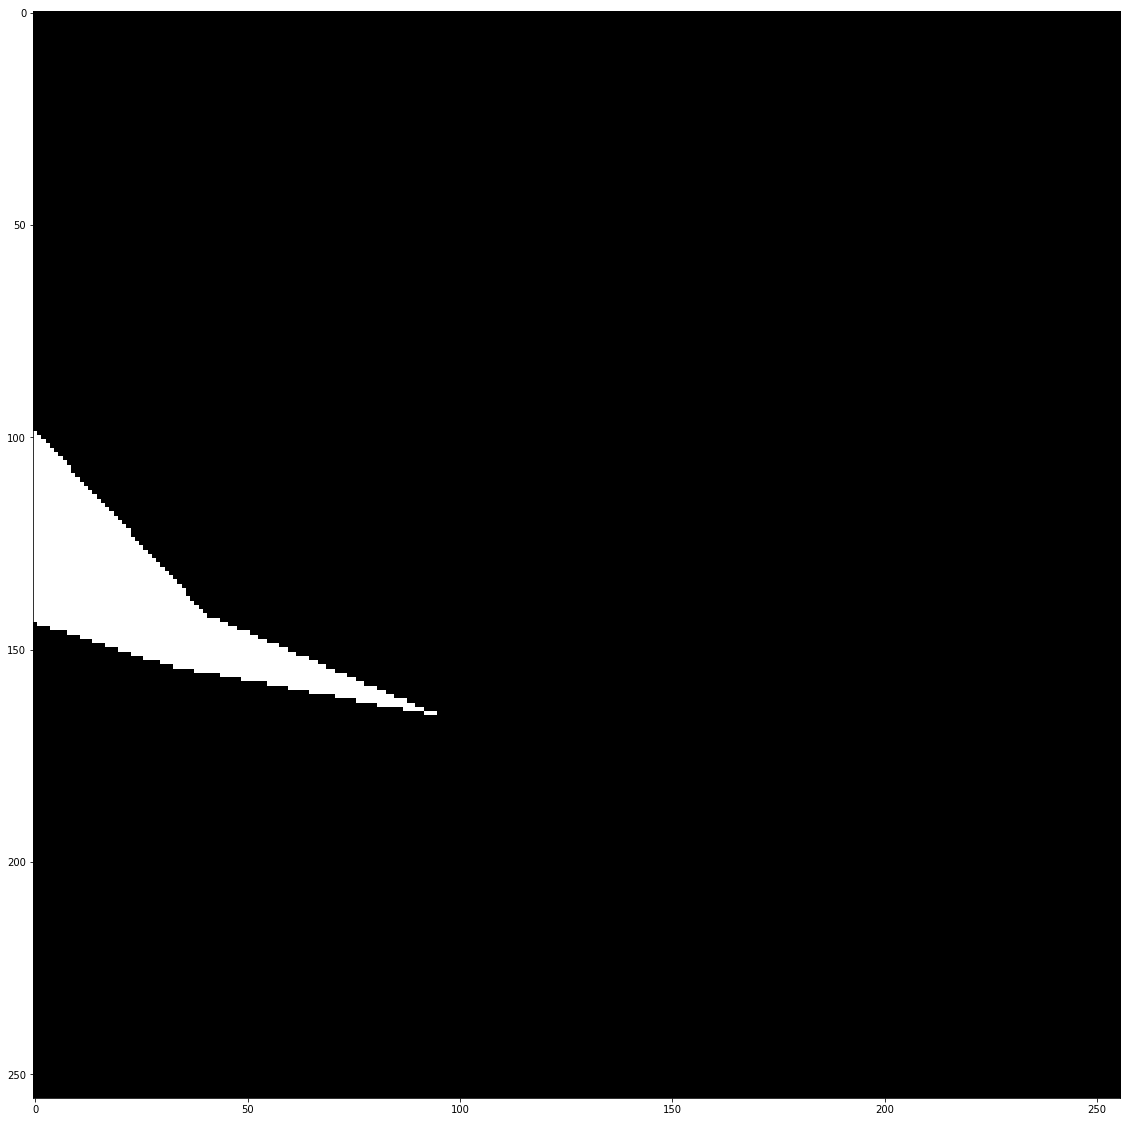

In [23]:
from datetime import datetime
import matplotlib.pyplot as plt
from openslide.deepzoom import DeepZoomGenerator 
%matplotlib inline

start = datetime.now()

f, ax = plt.subplots(figsize=(20,20))
ax.imshow(truth.read_region((156*256, 79*256),0,(256,256)))
end = datetime.now()
print('本段代码执行时间是:%.1f s'%(end-start).seconds)

0 0 134881 96660 30208 20096 20224 20480
本段代码执行时间是:7.0 s


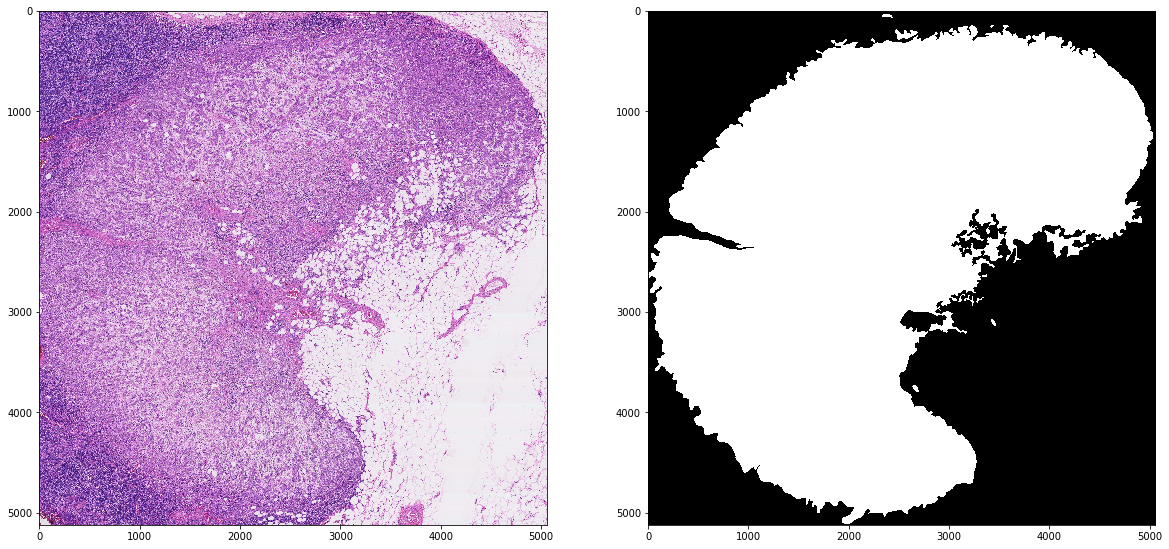

In [42]:
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

start = datetime.now()
s_image, m_image = path_to_slide(random_pic)
[[effective_x,effective_y,effective_widths,effective_heights],
 [tumor_leftup_x,tumor_leftup_y,mask_effective_widths,mask_effective_heights]] = eff_train[random_pic]

print(effective_x,effective_y,effective_widths,effective_heights,tumor_leftup_x,tumor_leftup_y,mask_effective_widths,mask_effective_heights)

# if mask_effective_widths<20000 and mask_effective_heights<20000 :
src_slide = s_image.read_region((tumor_leftup_x,tumor_leftup_y),2,(mask_effective_widths//4, mask_effective_heights//4))
src_mask = m_image.read_region((tumor_leftup_x,tumor_leftup_y),2,(mask_effective_widths//4, mask_effective_heights//4))

f, axes = plt.subplots(1,2,figsize=(20,20))
ax = axes.flatten()
_=ax[0].imshow(src_slide)
_=ax[1].imshow(src_mask)

end = datetime.now()
print('本段代码执行时间是:%.1f s'%(end-start).seconds)